## Learning Generalized Quasi-Geostrophic Models Using Deep Neural Numerical Models

Lguensat et al. https://arxiv.org/abs/1911.08856

This notebook presents the PyTorch written one-layer quasi geostrophic model used for the paper, this code is adapted for GPU use and could serve for training neural networks as done in the paper. To run properly you must use double precision (float64). For the moment it does not deal with land pixels, any help/collaboration is appreciated.

In [1]:
%matplotlib inline

# standard imports
import numpy as np
#import xarray as xr
#import netCDF4
import time 
import math
from math import pi
#import seaborn as sns
import matplotlib.pyplot as plt

### loading datasets (region near the Gulf stream, NATL60 data)
https://meom-group.github.io/swot-natl60/access-data.html

In [2]:
SSH_train = np.expand_dims(np.load('./Data/SSH_365Train_GS.npy'),1)[:,:,::-1,:].astype('float64')
lon_train = np.tile(np.load('./Data/LON_GS.npy')[::-1,:],(365,1,1,1)).astype('float64')
lat_train = np.tile(np.load('./Data/LAT_GS.npy')[::-1,:],(365,1,1,1)).astype('float64')
SSH_train.shape, lon_train.shape, lat_train.shape

((365, 1, 200, 200), (365, 1, 200, 200), (365, 1, 200, 200))

### import PyTorch 

In [3]:
import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

In [4]:
torch.backends.cudnn.deterministic = True

In [5]:
torch.__version__

'1.2.0'

In [6]:
!nvidia-smi

Thu Nov 28 16:17:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1E:00.0 Off |                    0 |
| N/A   38C    P0    43W / 300W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)
print(device)

cuda:0


## One-layer QG in PyTorch (written for GPU use)

In [8]:
class sshtoqRegression(nn.Module):
    def __init__(self, qg, nbiter):
        super(sshtoqRegression, self).__init__()  
        self.qg = qg
        self.nbiter = nbiter
        
    def forward(self, x):
        self.gradient_x_filter =  torch.cuda.DoubleTensor([-0.5, +0.5]).view([1, 1, 1, 2])
        self.gradient_x = torch.cuda.DoubleTensor([[-0.25, -0.25], [0, 0], [0.25, 0.25]]).view([1, 1, 3, 2])
        self.gradient_y_filter = torch.transpose(self.gradient_x_filter,2,3)
        self.gradient_y = torch.transpose(self.gradient_x,2,3)

        self.laplacian_x = torch.cuda.DoubleTensor([1, -2, 1]).view([1, 1, 1, 3])
        self.laplacian_y = torch.transpose(self.laplacian_x,2,3)

        self.diff_x_filter = torch.cuda.DoubleTensor([-1, +1]).view([1, 1, 1, 2])
        self.diff_y_filter = torch.transpose(self.diff_x_filter,2,3)

        self.gr1=torch.cuda.DoubleTensor([0.5, 0.5]).view([1, 1, 1, 2])
        self.gr2=torch.transpose(self.gr1,2,3)
        self.qf1=torch.cuda.DoubleTensor([1/6, -1, 1/2, 1/3]).view([1, 1, 1, 4])
        self.qf2=torch.transpose(self.qf1,2,3)
        self.qf1bis=torch.cuda.DoubleTensor([1/3, 1/2, -1, 1/6]).view([1, 1, 1, 4])
        self.qf2bis=torch.transpose(self.qf1bis, 2,3)
        self.diffv2_y_filter= torch.cuda.DoubleTensor([-1,0,+1]).view([1, 1, 3, 1])
        #########
        ssh_tensor,lon_input,lat_input = x
        q = self.sshtoq((ssh_tensor,lon_input,lat_input))
        q10 = self.dynqhardcoded((q,ssh_tensor,lon_input,lat_input))
        hh = self.CGblockZERO((q10,ssh_tensor,lon_input,lat_input)) #, rn, dn
        #######
        hb = ssh_tensor#hh
        for iterat in range(self.nbiter):
            hguess = 2*hh-hb
            hb = hh
            q10 = self.dynqhardcoded((q10,hh,lon_input,lat_input))
            hh = self.CGblockZERO((q10,hguess,lon_input,lat_input))#, rn, dn
        return hh

    def sshtoq(self, x):        
        ssh_tensor,lon_input,lat_input = x
        dx,dy,f0 = self.gridvar([lon_input,lat_input])
        laplaciansshx = F.conv2d(ssh_tensor, self.laplacian_x, padding=0)[:,:,2:-3,1:-2]*((9.81/(f0*(dx**2)))[:,:,2:-3,2:-3])
        laplaciansshy = F.conv2d(ssh_tensor, self.laplacian_y, padding=0)[:,:,1:-2,2:-3]*((9.81/(f0*(dy**2)))[:,:,2:-3,2:-3])
        zp = nn.ZeroPad2d((2, 3, 2, 3))
        if self.qg:
            return (-9.81*f0/(1.5**2))*ssh_tensor+ zp(laplaciansshx)+ zp(laplaciansshy) ##1.5 is the constant Rossby first baroclinic phase speed set to constant value in m/s
        else:
            return ###put here your neural net
    
    def Geostroph(self, x):
        ssh_tensor,lon_input,lat_input = x
        dx,dy,f0 = self.gridvar([lon_input,lat_input])
        zp1 = nn.ZeroPad2d((1,1,1,0))
        zp2 = nn.ZeroPad2d((1,0,1,1))
        vvv_QG = zp1(F.conv2d(ssh_tensor,self.gradient_y,padding=0))
        uuu_QG = zp2(F.conv2d(ssh_tensor,self.gradient_x,padding=0))
        return -9.81*uuu_QG/(f0*dy),9.81*vvv_QG/(f0*dx)
    
    def dynqhardcoded(self, x):
        q_tensor,ssh_tensor,lon_input,lat_input = x
        dx,dy,f0 = self.gridvar([lon_input,lat_input])
        zp1 = nn.ZeroPad2d((1,1,1,0))
        zp2 = nn.ZeroPad2d((1,0,1,1))
        vvv_QG = zp1(F.conv2d(ssh_tensor,self.gradient_y,padding=0))
        uuu_QG = zp2(F.conv2d(ssh_tensor,self.gradient_x,padding=0))
        if self.qg:
            v = 9.81*vvv_QG/(f0*dx)
            u = -9.81*uuu_QG/(f0*dy)
        else:
            v # put your neural net
            u # put your neural net
        #####
        utmp = F.conv2d(u, self.gr1, padding=0)[:,:,2:-2,2:-1]
        uplus = F.relu(utmp)
        uminus = -1*F.relu(-1*utmp)
        vtmp = F.conv2d(v, self.gr2, padding=0)[:,:,2:-1,2:-2]
        vplus = F.relu(vtmp)
        vminus = -1*F.relu(-1*vtmp)
        #########
        q1= F.conv2d(q_tensor[:,:,2:-2,0:-1], self.qf1)
        q2= F.conv2d(q_tensor[:,:,2:-2,1:], self.qf1bis)
        q3= F.conv2d(q_tensor[:,:,:-1,2:-2], self.qf2)
        q4= F.conv2d(q_tensor[:,:,1:,2:-2], self.qf2bis)
        #########
        adding1 = (uminus*q2-uplus*q1)/(dx[:,:,2:-2,2:-2])
        adding2 = (vminus*q4-vplus*q3)/(dy[:,:,2:-2,2:-2])
        f0tmp = F.conv2d(f0[:,:,1:-1,2:-2], self.diffv2_y_filter)
        vtmp2 = ((-1.*f0tmp)/(2.*dy[:,:,2:-2,2:-2]))*vtmp
        rq = (adding1+adding2+vtmp2)[:,:,:-1,:-1]
        ########
        zp3 = nn.ZeroPad2d((2,3,2,3))
        return q_tensor + 600.*zp3(rq) #_______Attention______________dt=10min=600s
    
    def CGblockZERO(self, x):
        ## one iteration of the conjugate gradient
        q_tensor, map_tensor, lon_input, lat_input = x
        Fssh = self.sshtoq((map_tensor, lon_input, lat_input)) 
        rr = q_tensor-Fssh
        Frr = self.sshtoq((rr, lon_input, lat_input))
        ########## alpha
        alpha = torch.sum(rr*rr, dim=(1,2,3), keepdim=True)/torch.sum(rr*Frr, dim=(1,2,3), keepdim=True)
        ##############
        mapnext = map_tensor + alpha*rr
        #rrnext = q_tensor - self.sshtoq((mapnext, lon_input, lat_input))
        ########## beta
        #beta = torch.sum(rrnext*rrnext, dim=(1,2,3), keepdim=True)/torch.sum(rr*rr, dim=(1,2,3), keepdim=True)
        ##############
        #dir1 = rrnext + beta*rr
        return mapnext#, rrnext, dir1

    def gridvar(self, x):
        lon_tensor,lat_tensor = x
        f0= 2.*2.*pi/86164.*torch.sin(lat_tensor*pi/180.)
        dlony=F.conv2d(lon_tensor[:,:,1:,1:-1], self.diff_y_filter, padding=0)
        dlaty=F.conv2d(lat_tensor[:,:,1:,1:-1], self.diff_y_filter, padding=0)
        dlonx=F.conv2d(lon_tensor[:,:,1:-1,1:], self.diff_x_filter, padding=0)
        dlatx=F.conv2d(lat_tensor[:,:,1:-1,1:], self.diff_x_filter, padding=0)
        tmp=torch.cos(lat_tensor[:,:,1:-1,1:-1]*pi/180.)
        dx=torch.sqrt((dlonx*111000.*tmp)**2 + (dlatx*111000.)**2)
        dy=torch.sqrt((dlony*111000.*tmp)**2 + (dlaty*111000.)**2)
        return F.pad(dx,(1,1,1,1),'replicate'), F.pad(dy,(1,1,1,1),'replicate'), f0  

## Test

In [9]:
randindex = np.random.randint(365)
randindex

161

#### the code already does one iteration, so for a 24h SSH forecasting with a 10min time step, 144-1=143 steps are needed

In [10]:
netqg = sshtoqRegression(qg=True, nbiter=143).double().to(device)
netqg.eval()

res_qg = netqg([torch.from_numpy(SSH_train[None,randindex,:,:,:]).to(torch.float64).to(device),
            torch.from_numpy(lon_train[None,randindex,:,:,:]).to(torch.float64).to(device),
            torch.from_numpy(lat_train[None,randindex,:,:,:]).to(torch.float64).to(device)])

## Comparison with the original Python code

In [11]:
import sys
sys.path.insert(0,'/home/lguensar/deepocean/QGmodel')
from moddyn import h2uv,qrhs
from modelliptic import pv2h, h2pv
import modgrid
#####

In [12]:
c=SSH_train[0,0,:,:]*0. + 1.5 # Set constant Rossby first baroclinic phase speed to constant value in m/s
dt=600 ##10min  propagator time step

h = SSH_train[randindex,0,:,:]
grdtst=modgrid.grid(h, c, 0., lon_train[randindex,0,:,:], lat_train[randindex,0,:,:])
qQG,= h2pv(h,grdtst)

hb=+h 
for step in range(144): # 144 because 10min  
    #init
    hguess=2*h-hb
    hb=+h
    qb=+qQG
    #forecasting
    # 1/ 
    u,v, = h2uv(h,grdtst)

    # 2/
    rq, = qrhs(u,v,qb,grdtst,+1)

    # 3/    
    qQG = qb + dt*rq

    # 4/
    h,=pv2h(qQG,hguess,grdtst,1) ##### one CG iteration

Text(0.5, 1.0, 'qg_pytorch error')

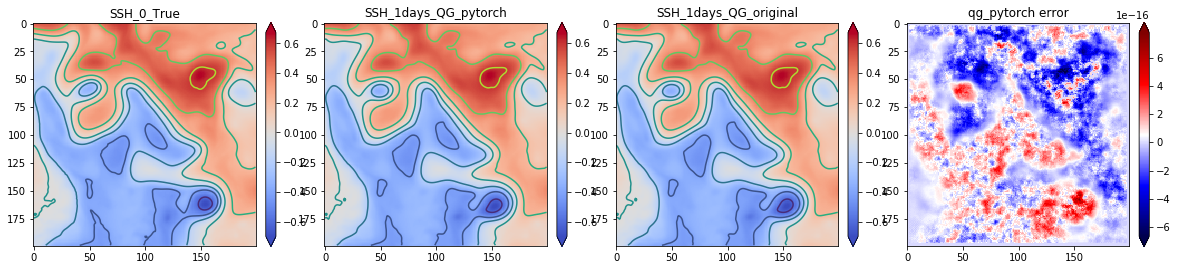

In [13]:
plt.figure(figsize=(20, 10))

plt.subplot(141)
plt.contour(SSH_train[randindex,0,:,:], cmap='viridis')
plt.imshow(SSH_train[randindex,0,:,:], cmap='coolwarm')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.5,0.5)
plt.title('SSH_0_True')

plt.subplot(142)
plt.contour((res_qg[0,0,:,:]).detach().cpu().numpy(), cmap='viridis')
plt.imshow((res_qg[0,0,:,:]).detach().cpu().numpy(), cmap='coolwarm')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.5,0.5)
plt.title('SSH_1days_QG_pytorch')

plt.subplot(143)
plt.contour(h, cmap='viridis')
plt.imshow(h, cmap='coolwarm')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.5,0.5)
plt.title('SSH_1days_QG_original')

plt.subplot(144)
plt.imshow(h-(res_qg[0,0,:,:]).detach().cpu().numpy(), cmap='seismic')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.2,0.2)
plt.title('qg_pytorch error')

In [14]:
from sklearn.metrics import mean_squared_error

mean_squared_error(h,res_qg[0,0,:,:].detach().cpu().numpy())

1.9161954653080026e-32

## test the stability, check forecasting at 20 days

In [15]:
netqg = sshtoqRegression(qg=True, nbiter=20*144-1).double().to(device)
netqg.eval()

res_qg = netqg([torch.from_numpy(SSH_train[None,randindex,:,:,:]).to(torch.float64).to(device),
            torch.from_numpy(lon_train[None,randindex,:,:,:]).to(torch.float64).to(device),
            torch.from_numpy(lat_train[None,randindex,:,:,:]).to(torch.float64).to(device)])

In [16]:
c=SSH_train[0,0,:,:]*0. + 1.5 # Set constant Rossby first baroclinic phase speed to constant value in m/s
dt=600 ##10min  propagator time step

h = SSH_train[randindex,0,:,:]
grdtst=modgrid.grid(h, c, 0., lon_train[randindex,0,:,:], lat_train[randindex,0,:,:])
qQG,= h2pv(h,grdtst)

hb=+h 
for step in range(144*20): # 144 because 10min  
    #init
    hguess=2*h-hb
    hb=+h
    qb=+qQG
    #forecasting
    # 1/ 
    u,v, = h2uv(h,grdtst)

    # 2/
    rq, = qrhs(u,v,qb,grdtst,+1)

    # 3/    
    qQG = qb + dt*rq

    # 4/
    h,=pv2h(qQG,hguess,grdtst,1) ##### one CG iteration

Text(0.5, 1.0, 'qg_pytorch error')

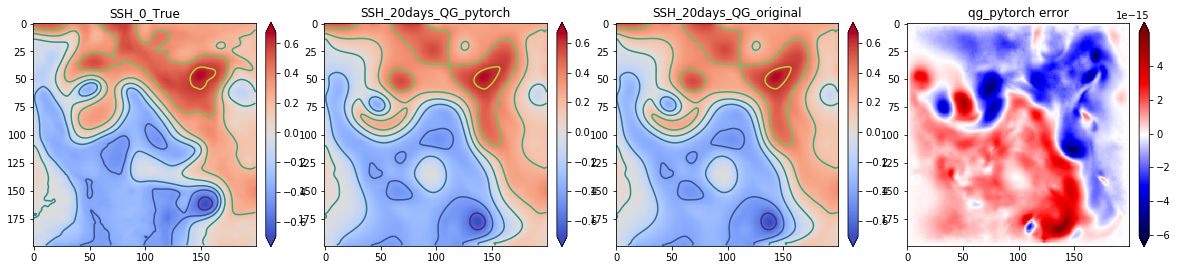

In [19]:
plt.figure(figsize=(20, 10))

plt.subplot(141)
plt.contour(SSH_train[randindex,0,:,:], cmap='viridis')
plt.imshow(SSH_train[randindex,0,:,:], cmap='coolwarm')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.5,0.5)
plt.title('SSH_0_True')

plt.subplot(142)
plt.contour((res_qg[0,0,:,:]).detach().cpu().numpy(), cmap='viridis')
plt.imshow((res_qg[0,0,:,:]).detach().cpu().numpy(), cmap='coolwarm')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.5,0.5)
plt.title('SSH_20days_QG_pytorch')

plt.subplot(143)
plt.contour(h, cmap='viridis')
plt.imshow(h, cmap='coolwarm')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.5,0.5)
plt.title('SSH_20days_QG_original')

plt.subplot(144)
plt.imshow(h-(res_qg[0,0,:,:]).detach().cpu().numpy(), cmap='seismic')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.2,0.2)
plt.title('qg_pytorch error')

In [18]:
mean_squared_error(h,res_qg[0,0,:,:].detach().cpu().numpy())

2.5481176301907915e-30